In [1]:
import numpy as np

def findPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2))
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

In [2]:
from scipy.optimize import leastsq
import numpy as np

def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])
    sigma = (mu/280000)/(2*np.log(2))
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c[1]

In [3]:
import numpy as np

def getAllMeans(peaks):
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = np.zeros(n)
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        means[i] = getMean(peak)
    return means

In [4]:
import pandas as pd
import numpy as np

def identifyPeaks(data, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peakMeans = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:
            peaklist.iloc[i,2] = peakMeans[np.argmin(abs(peakMeans - trueValue[i]))]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
    return peaklist.drop(unidentified)

In [5]:
import numpy as np
import pandas as pd

def readFile(fileName):
    return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")

In [6]:
# example

import numpy as np
import pandas as pd

data = readFile("data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv")

peakMeans = getAllMeans(data)
print(peakMeans)

[ 61.97269482  61.98244144  61.98283679  61.98335711  61.98384305
  61.9883735   61.99202763  61.99266712  61.99384863  62.0040634
  62.98543084  62.99261361  63.99263084  76.06652499  86.1982139
  88.98813146 103.00376407 109.09415801 112.98567157 117.01940061
 123.98871838 124.9391244  124.98400175 124.98764312 124.98846997
 125.02894401 125.98103635 125.98822466 126.98827203 133.01427355
 133.98434386 141.52596266 142.49013706 145.01425262 146.99350067
 147.02993603 148.03331565 159.02991438 161.00918878 161.04557078
 165.99936357 173.04552876 175.02476644 175.98114797 185.04556037
 187.06121246 189.04043631 192.01497819 193.94260186 194.98867711
 201.04044571 201.07703106 203.05613085 206.03064565 208.00990814
 208.04628151 210.0255283  213.0768901  215.05625913 215.09241787
 217.07169499 220.00986659 220.0462059  222.025488   224.00476033
 224.04125145 231.08745669 234.02549221 234.06190774 235.06539123
 236.04117618 236.0775128  238.02033118 244.98541835 248.04119327
 249.0446832

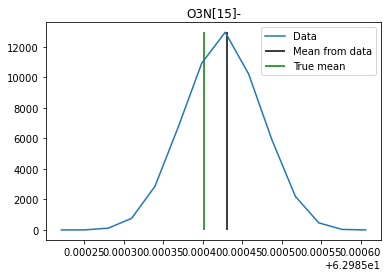

In [9]:
# Plot a peak

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

peakindex = findPeakIndices(data)
peakMeans = getAllMeans(data)
peaklist = pd.read_csv("peaklist.csv")
peaklist = identifyPeaks(data, peaklist, 0.002)

# Choose peak
i = 1

ii = int(peaklist.iloc[i,3])
peak = data[peakindex[ii,0]:peakindex[ii,1]+1]
plt.plot(peak[:,0],peak[:,1])
plt.vlines(peaklist.iloc[i,2],0,max(peak[:,1]))
plt.vlines(peaklist.iloc[i,1],0,max(peak[:,1]), color = "green")
plt.legend(["Data","Mean from data","True mean"])
plt.title(peaklist.iloc[i,0])
plt.show()

In [10]:
import pandas as pd
import numpy as np

peaklist = identifyPeaks(data, pd.read_csv("peaklist.csv"), 0.002)
peaklist

,formula,mz,observed,peak
2,O3N-,61.988366,61.988374,5.0
3,O3N[15]-,62.985401,62.985431,10.0
4,O2O[17]N-,62.992584,62.992614,11.0
5,O2O[18]N-,63.992613,63.992631,12.0
10,C2HO4-,88.988032,88.988131,15.0
...,...,...,...,...
263,C14H16O5NF-,297.101799,297.101848,96.0
267,C11H16O9N-,306.083055,306.082593,97.0
270,C10H14O10N-,308.062319,308.062112,98.0
275,C10H16O10N-,310.077969,310.077606,99.0
